# CITRA DATA

### Path Data

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mediapipe as mp
import random
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Path dataset
dataset_path = r"D:\Belajar Machine Learning\famscreen_ml\dataset"

# FUNGSI PROGRAM

### Fungsi Konversi Ketegori Umur , Ekstraksi Fitur LBP, Enhancement Citra, Deteksi Wajah, & Augmentasi Gambar

In [ ]:
# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
    '''
    Fungsi ini mengonversi umur menjadi kategori umur berdasarkan rentang usia.
    '''
    if 1 <= age <= 10:
        return 0  # Anak-anak
    elif 11 <= age <= 18:
        return 1  # Remaja
    elif 19 <= age <= 59:
        return 2  # Dewasa
    elif 60 <= age <= 110:
        return 3  # Lansia
    return -1  # Label tidak valid

# Fungsi untuk ekstraksi fitur LBP
def extract_lbp_features(image, radius=2, n_points=16):
    '''
    Fungsi ini menghitung fitur LBP dari gambar untuk digunakan dalam pengenalan wajah.
    LBP digunakan untuk mengekstraksi informasi tekstur dari gambar wajah.
    
    Menghasilkan:
    lbp_hist - Histogram yang dinormalisasi dari pola LBP.
    '''
    
    # Hitung LBP pada gambar
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    
    # Hitung histogram dari LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalisasi histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi agar jumlah histogram = 1
    return lbp_hist

# Fungsi untuk enhancement citra
def enhance_image(image):
    '''
    Fungsi ini digunakan untuk meningkatkan kualitas gambar dengan menerapkan filter penajaman (sharpening).
    Jika gambar berwarna (BGR), akan dikonversi ke grayscale terlebih dahulu.
    
    Menghasilkan:
    enhanced_img - Gambar yang telah ditingkatkan kualitasnya dengan filter sharpening.
    '''
    
    # Periksa apakah citra sudah grayscale
    if len(image.shape) == 3:  # Jika memiliki 3 kanal (BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # Jika sudah grayscale, gunakan langsung
    
    # Mendefinisikan kernel sharpening (3x3)
    kernel = np.array([
        [0, -0.5, 0],
        [-0.5, 3, -0.5],
        [0, -0.5, 0]
    ])

    
    # Melakukan operasi filter untuk sharpening
    enhanced_img = cv2.filter2D(gray, -1, kernel)
    
    return enhanced_img

# Fungsi untuk face detection dan crooping
def detect_face_mediapipe(img):
    '''
    Fungsi ini menggunakan Mediapipe untuk mendeteksi wajah dan landmark.
    Jika wajah terdeteksi, fungsi mengembalikan citra wajah yang sudah di-crop berdasarkan bounding box dari landmark.

    Menghasilkan:
    cropped_face - Wajah yang sudah di-crop (atau None jika tidak ada wajah yang terdeteksi).
    '''
    
    # Konversi ke RGB karena Mediapipe bekerja di ruang warna RGB
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    results = face_mesh.process(rgb_img)

    if not results.multi_face_landmarks:
        return None  # Tidak ada wajah yang terdeteksi

    # Ambil landmark wajah pertama
    face_landmarks = results.multi_face_landmarks[0]

    # Ambil semua koordinat landmark
    h, w = img.shape[:2]  # Ambil height dan width saja (abaikan channel jika ada)
    landmarks_points = [
        (int(landmark.x * w), int(landmark.y * h)) for landmark in face_landmarks.landmark
    ]

    # Buat bounding box untuk wajah
    x_min = min([point[0] for point in landmarks_points])
    y_min = min([point[1] for point in landmarks_points])
    x_max = max([point[0] for point in landmarks_points])
    y_max = max([point[1] for point in landmarks_points])

    # Crop wajah berdasarkan bounding box
    cropped_face = img[y_min:y_max, x_min:x_max]
    return cropped_face

# Inisialisasi Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Fungsi untuk augmentasi gambar
def augment_image(image):
    ''' 
    Fungsi ini melakukan augmentasi pada gambar input dengan dua teknik: 
    1. Flip horizontal secara acak
    2. Rotasi secara acak antara -10 hingga 10 derajat
    
    Menghasilkan :
    - image: Gambar yang sudah di-augmentasi (flip dan/atau rotasi)
    '''
    
    # Flip horizontal secara acak
    if random.choice([True, False]):
        image = cv2.flip(image, 1)
    # Rotasi 10 derajat secara acak
    if random.choice([True, False]):
        h, w = image.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle=random.uniform(-10, 10), scale=1.0)
        image = cv2.warpAffine(image, M, (w, h))
        
    return image       

# DATA PROCESSING & EKSTRAKSI FITUR

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Mendapatkan daftar file gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".png"))]
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
    parts = image_file.split('_')
    age = int(parts[0])  # Mengambil usia dari nama file index ke 0
    age_category = categorize_age(age)
    
    if age_category in [0, 1, 2, 3] :
        if age_category not in image_data_by_age:
            image_data_by_age[age_category] = []
        image_data_by_age[age_category].append(image_file)
        
# List untuk menyimpan gambar yang telah diproses
processed_images = []

# Menggabungkan augmentasi pada gambar sebelum ekstraksi fitur
for age_category, files in image_data_by_age.items():
    for image_file in files:
        image_path = os.path.join(dataset_path, image_file)
        
        # Baca gambar dan konversi ke grayscale
        image = cv2.imread(image_path)
        
        # Melakukan enhancement pada gambar wajah yang sudah dipotong
        enhanced_img = enhance_image(image)
        
        # Menggunakan fungsi detect_face_mediapipe untuk mendeteksi wajah dan crop
        cropped_face = detect_face_mediapipe(enhanced_img)
        
        if cropped_face is not None and cropped_face.size > 0:
            
            # Menerapkan augmentasi gambar
            augmented_face_image = augment_image(cropped_face)
            
            # Menyimpan gambar yang telah diproses (enhanced dan augmented)
            processed_images.append((cropped_face,augmented_face_image))
            
            # Ekstraksi fitur LBP dari gambar cropped face
            lbp_features_cropped = extract_lbp_features(cropped_face)
            
            # Ekstraksi fitur LBP dari gambar hasil augmentasi
            lbp_features_augmented = extract_lbp_features(augmented_face_image)
            
            # Menggabungkan label umur dan fitur LBP ke dalam list data
            data.append([age_category] + lbp_features_cropped.tolist())
            data.append([age_category] + lbp_features_augmented.tolist())

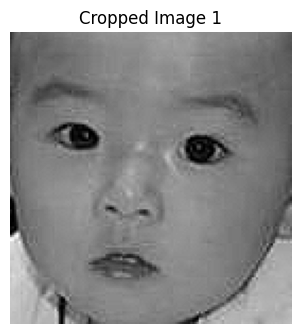

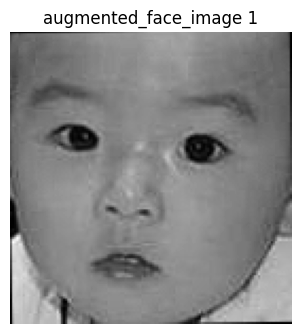

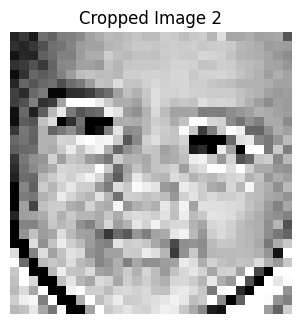

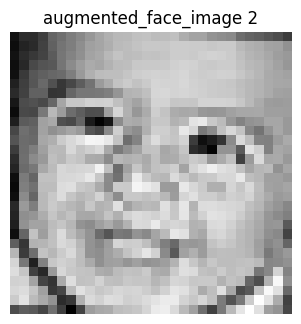

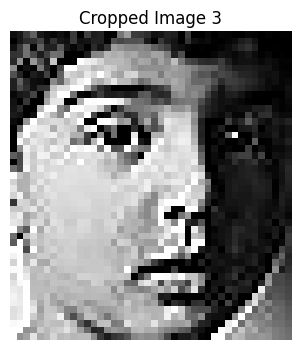

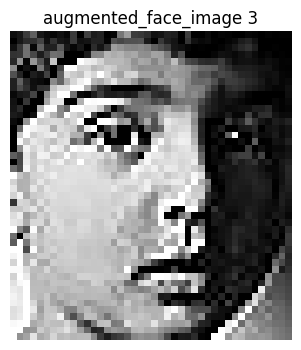

In [4]:
# Pilih 3 gambar secara acak untuk ditampilkan
random_images = random.sample(processed_images, 3)

# Menampilkan 3 gambar acak yang telah diproses
for i, (cropped_face, augmented_face_image) in enumerate(random_images):
    plt.figure(figsize=(8, 6))
    
    # Gambar Enhanced
    plt.subplot(1, 2, 1)
    plt.title(f'Cropped Image {i+1}')
    plt.imshow(cropped_face, cmap='gray')
    plt.axis('off')

    plt.figure(figsize=(8, 6))
    
    # Gambar Enhanced
    plt.subplot(1, 2, 1)
    plt.title(f'augmented_face_image {i+1}')
    plt.imshow(augmented_face_image, cmap='gray')
    plt.axis('off')
    
    plt.show()

### Menyimpan Data Gambar ke File CSV

In [ ]:
num_lbp_features = len(lbp_features_cropped)

columns = ['age_category'] + [f'pixel_{i}' for i in range(num_lbp_features)]

df = pd.DataFrame(data, columns=columns)
df.to_csv("svm_sampled.csv", index=False)

# CEK INFORMASI DATA

### Read Data CSV

In [ ]:
# Membaca data dari CSV
df = pd.read_csv("svm_sampled.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             3  0.029815  0.027397  0.031265  0.031587  0.035133  0.044480   
1             3  0.029815  0.027397  0.031265  0.031587  0.035133  0.044319   
2             3  0.050491  0.039153  0.031847  0.027816  0.027110  0.031192   
3             3  0.045503  0.029630  0.030335  0.028319  0.028823  0.035576   
4             3  0.073018  0.044781  0.036741  0.026216  0.022024  0.024748   

    pixel_6   pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  \
0  0.063014  0.109750  0.131346  0.097180  0.052538  0.034005  0.030137   
1  0.063175  0.109750  0.131507  0.097180  0.052377  0.034005  0.030137   
2  0.045100  0.066919  0.084757  0.075787  0.042681  0.034417  0.027564   
3  0.048073  0.071655  0.112270  0.082439  0.047468  0.035122  0.028672   
4  0.030168  0.046592  0.058869  0.047416  0.030243  0.024150  0.023895   

   pixel_13  pixel_14  pixel_15  pixel_16  pixel_17  
0  0.023368  0.02111

### EDA - Distribusi Data

age_category
2    8032
0    6002
3    2192
1    1710
Name: count, dtype: int64


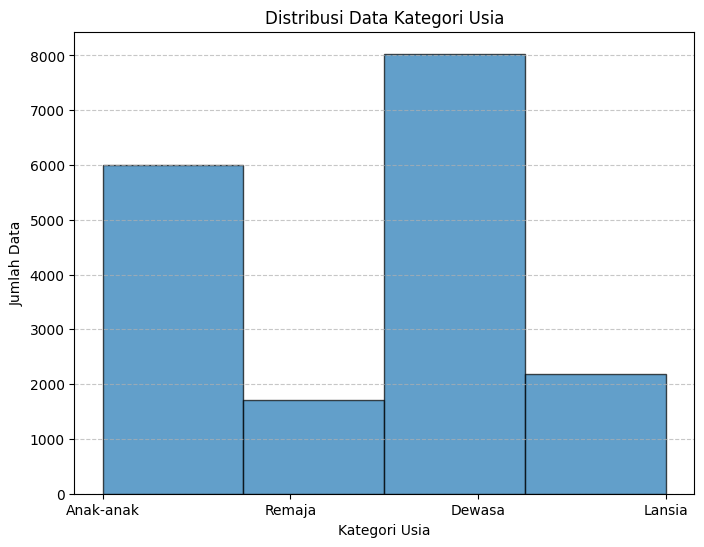

In [ ]:
# Memeriksa distribusi kategori usia
age_distribution = df['age_category']
print(age_distribution.value_counts())

# Membuat histogram
plt.figure(figsize=(8, 6))
plt.hist(age_distribution, bins=4, edgecolor='black', alpha=0.7)
plt.title("Distribusi Data Kategori Usia")
plt.xlabel("Kategori Usia")
plt.ylabel("Jumlah Data")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Anak-anak", "Remaja", "Dewasa", "Lansia"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# DATA SPLITTING

### Memisah Fitur-Target & Menyeimbangkan Data

In [8]:
# Memisahkan fitur dan target
X = df.drop(columns=['age_category'])
y = df['age_category']

# Menggunakan SMOTE untuk menyeimbangkan kategori
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### EDA - Distribusi Data Setelah Diseimbangkan

Distribusi kategori usia setelah SMOTE:
Counter({3: 8032, 0: 8032, 1: 8032, 2: 8032})


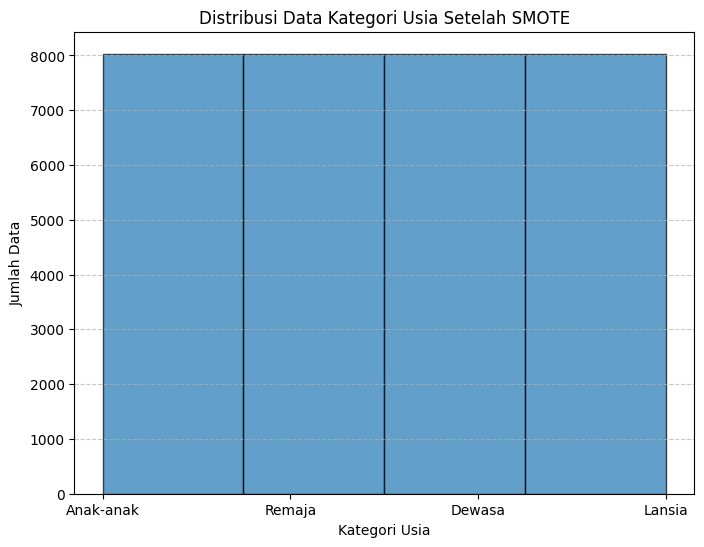

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Memeriksa distribusi kategori usia setelah SMOTE
print("Distribusi kategori usia setelah SMOTE:")
print(Counter(y_resampled))

# Membuat histogram setelah SMOTE
plt.figure(figsize=(8, 6))
plt.hist(y_resampled, bins=4, edgecolor='black', alpha=0.7)  # 4 bins untuk 4 kategori
plt.title("Distribusi Data Kategori Usia Setelah SMOTE")
plt.xlabel("Kategori Usia")
plt.ylabel("Jumlah Data")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Anak-anak", "Remaja", "Dewasa", "Lansia"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# PELATIHAN MODEL (SVM)

In [ ]:
# Split data yang telah diseimbangkan
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Grid Search untuk SVM RBF
param_grid_rbf = {'C': [1e-3, 1, 1e3, 1e5], 'gamma': [1e-3, 1, 1e3]}
svm_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)
svm_rbf.fit(X_train, y_train)

# Menyimpan model yang terbaik
best_rbf_model = svm_rbf.best_estimator_

# Evaluasi model
y_pred_rbf = best_rbf_model.predict(X_test)

# Menampilkan hasil evaluasi
print("Akurasi Model SVM RBF:", accuracy_score(y_test, y_pred_rbf) * 100, "%")
print("\nClassification Report (RBF SVM):\n", classification_report(y_test, y_pred_rbf))

Akurasi Model SVM RBF: 90.33613445378151 %

Classification Report (RBF SVM):
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      1626
           1       0.91      0.97      0.94      1612
           2       0.88      0.80      0.84      1612
           3       0.93      0.97      0.95      1576

    accuracy                           0.90      6426
   macro avg       0.90      0.90      0.90      6426
weighted avg       0.90      0.90      0.90      6426



### EDA - Menampilkan Distribusi Prediksi

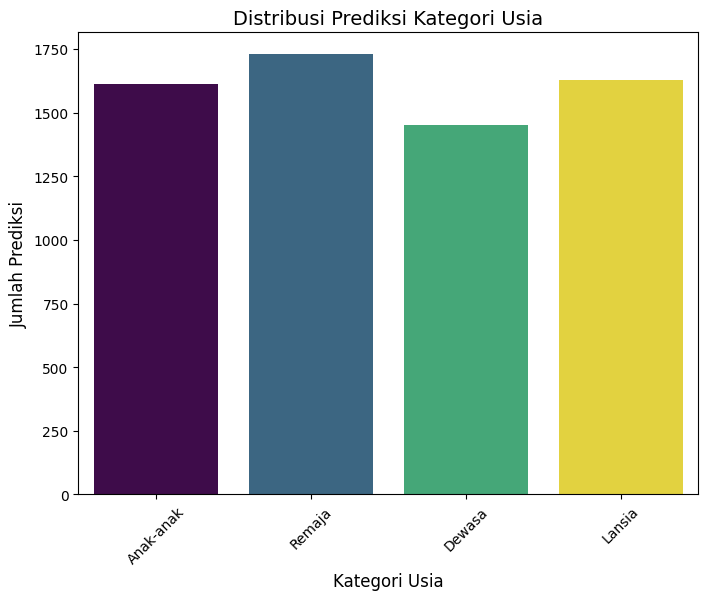

In [ ]:
# Menampilkan distribusi prediksi
def plot_prediction_distribution(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y_pred, palette="viridis", hue=y_pred, legend=False)  # Menetapkan hue=y_pred
    plt.title("Distribusi Prediksi Kategori Usia", fontsize=14)
    plt.xlabel("Kategori Usia", fontsize=12)
    plt.ylabel("Jumlah Prediksi", fontsize=12)
    plt.xticks(ticks=[0, 1, 2, 3], labels=["Anak-anak", "Remaja", "Dewasa", "Lansia"], rotation=45)
    plt.show()

# Memanggil fungsi untuk menampilkan distribusi prediksi
plot_prediction_distribution(y_test, y_pred_rbf)

# MODEL EVALUATION

### Menggunakan Confusion Matrix

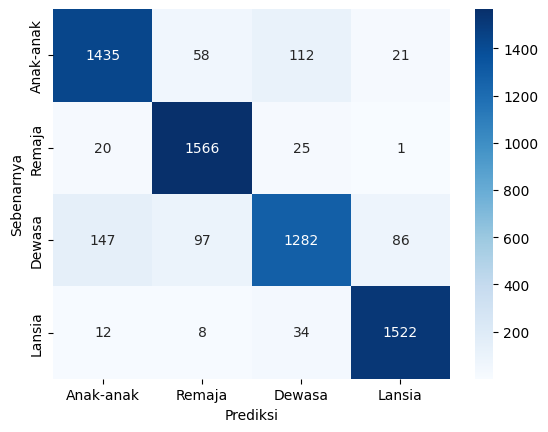

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anak-anak', 'Remaja', 'Dewasa', 'Lansia'], yticklabels=['Anak-anak', 'Remaja', 'Dewasa', 'Lansia'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show() 

In [ ]:
# Menyimpan model menggunakan joblib
joblib.dump(best_rbf_model, "famscreen_svm_model.pkl")

['famscreen_model.pkl']

In [ ]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_svm_model.pkl')

# PENGUJIAN MODEL MENGGUNAKAN INPUT GAMBAR

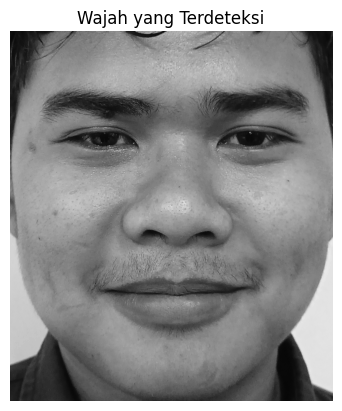

Fitur LBP: [[0.06210618 0.03868102 0.03323956 0.02930639 0.02444526 0.02635153
  0.02879349 0.03666932 0.04075255 0.04104604 0.03297646 0.03150805
  0.03099705 0.03773881 0.04265597 0.03659333 0.09043237 0.33570659]]


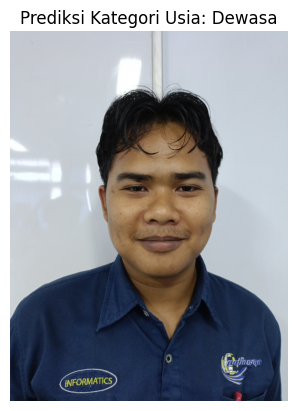

2


In [ ]:
# Fungsi untuk memproses gambar dan memprediksi
def predict_age_category(image_path, model):
    # Baca gambar
    image = cv2.imread(image_path)
    
    enhanced_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Pastikan gambar grayscale
    
    # Deteksi wajah dan crop gambar wajah
    cropped_face = detect_face_mediapipe(enhanced_img)
    
    if cropped_face is not None:
        # Visualisasi wajah yang terdeteksi
        plt.imshow(cropped_face, cmap='gray')
        plt.title("Wajah yang Terdeteksi")
        plt.axis("off")
        plt.show()
    else:
        print("Tidak ada wajah terdeteksi dalam gambar.")
        return None, image

    
    if cropped_face is not None:
        # Ekstraksi fitur LBP dari gambar wajah yang terdeteksi
        lbp_features = extract_lbp_features(cropped_face)
        
        # Jika model dilatih dengan DataFrame, pastikan input memiliki nama kolom yang sesuai
        lbp_features = np.array(lbp_features).reshape(1, -1)  # Ubah menjadi format 2D untuk prediksi
        
        # Ambil semua kolom kecuali 'age_category'
        feature_names = df.columns[1:]  

        # Membuat DataFrame untuk prediksi
        lbp_features_df = pd.DataFrame(lbp_features, columns=feature_names)
        
        # Debugging: Cetak fitur yang dihasilkan
        print("Fitur LBP:", lbp_features)
        
        # Prediksi kategori umur menggunakan model
        age_category_pred = model.predict(lbp_features_df)
        
        return age_category_pred[0], image  # Mengembalikan kategori dan gambar asli
    else:
        return None, image  # Tidak ada wajah terdeteksi dalam gambar

# Fungsi untuk menampilkan gambar dengan kategori usia
def display_image_with_prediction(image, age_category):
    # Map prediksi usia ke kategori
    age_categories = {0: "Anak-anak", 1: "Remaja", 2: "Dewasa", 3: "Lansia"}
    
    if age_category is not None:
        label = age_categories.get(age_category, "Tidak Dikenal")
    else:
        label = "Tidak Ada Wajah Terdeteksi"
    
    # Menampilkan gambar dengan label
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB untuk matplotlib
    plt.title(f"Prediksi Kategori Usia: {label}")
    plt.axis("off")  # Menonaktifkan axis
    plt.show()

# Contoh menggunakan gambar baru untuk prediksi
image_path = r"D:\Belajar Machine Learning\famscreen_ml\images\imageFile.jpg"  # Ganti dengan path gambar yang ingin diuji
predicted_age_category, image = predict_age_category(image_path, model)

# Menampilkan hasil prediksi dan gambar
display_image_with_prediction(image, predicted_age_category)
print(predicted_age_category)

